In [1]:
import os, sys
sys.path.insert(0, os.path.abspath(os.path.join("..", "..")))

# Fixed triggers

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import datetime
import open_cp.data
import open_cp.sources.sepp as source_sepp
import open_cp.logger
open_cp.logger.log_to_true_stdout("sepp")
open_cp.logger.log_to_true_stdout("open_cp")
import sepp.sepp_fixed
import sepp.sepp_full

## The background sampler we'll use

In [3]:
class GridPoissonSampler(source_sepp.Sampler):
    def __init__(self, grid, rates, clustered=False):
        self._grid = grid
        self._rates = np.asarray(rates)
        assert (grid.yextent, grid.yextent) == self._rates.shape
        self._clustered = clustered
    
    def sample(self, start_time, end_time):
        points = []
        dt = end_time - start_time
        event_counts = np.random.poisson(dt * self._rates)
        for i in range(event_counts.shape[0]):
            for j in range(event_counts.shape[1]):
                times = np.random.random(event_counts[i,j]) * dt + start_time
                if self._clustered:
                    xcs = (0.4 + 0.2 * np.random.random(event_counts[i,j])) * self._grid.xsize
                    ycs = (0.4 + 0.2 * np.random.random(event_counts[i,j])) * self._grid.ysize
                else:
                    xcs = np.random.random(event_counts[i,j]) * self._grid.xsize
                    ycs = np.random.random(event_counts[i,j]) * self._grid.ysize
                xcs += self._grid.xoffset + j * self._grid.xsize
                ycs += self._grid.yoffset + i * self._grid.ysize
                for t, x, y in zip(times, xcs, ycs):
                    points.append([t,x,y])
        points = np.asarray(points).T
        return self._order_by_time(points)

In [4]:
grid = sepp.sepp_grid.ConcreteBoundedGrid(50, 50, 0, 0, 10, 10)
rates = np.random.random(size=(10,10)) / 10
bk_sampler = GridPoissonSampler(grid, rates)
tr_sampler = source_sepp.InhomogeneousPoissonFactors(source_sepp.Exponential(10, 0.5),
                source_sepp.GaussianSpaceSampler([0,0], [2,2], 0))
simulate = source_sepp.SelfExcitingPointProcess(bk_sampler, tr_sampler)

In [5]:
details = simulate.sample_with_details(0, 365)

## Triggering

Seems exponential in time and Gaussian in space, as expected

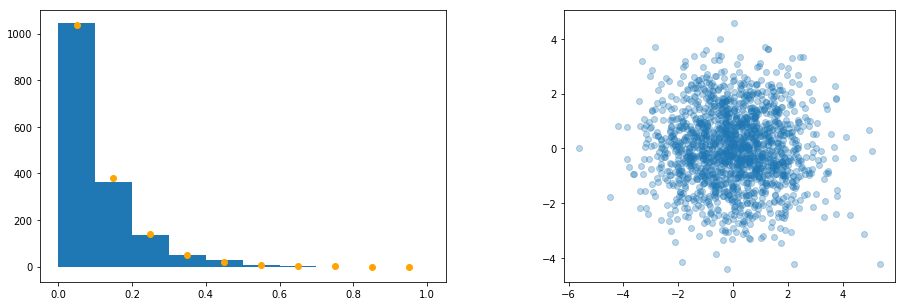

In [6]:
fig, axes = plt.subplots(ncols=2, figsize=(16,5))

axes[0].hist(details.trigger_deltas[0], bins=np.linspace(0,1,11))
x = np.linspace(0,1,11)
y = details.trigger_deltas.shape[1] * (np.exp(-10*x)[:-1] - np.exp(-10*x)[1:])
x += (x[1] - x[0])/2
axes[0].scatter(x[:-1], y, color="orange", zorder=10)
axes[1].scatter(*details.trigger_deltas[1:,], alpha=0.3)
axes[1].set_aspect(1)
None

In [7]:
print("Estimated omega =",
    1 / np.mean(details.trigger_deltas[0]) )
print("Estimated sigma^2 =",
    np.sum(details.trigger_deltas[1:]**2) / (2 * details.trigger_deltas.shape[1]) )

Estimated omega = 9.97743376027
Estimated sigma^2 = 2.00653441386


## Background

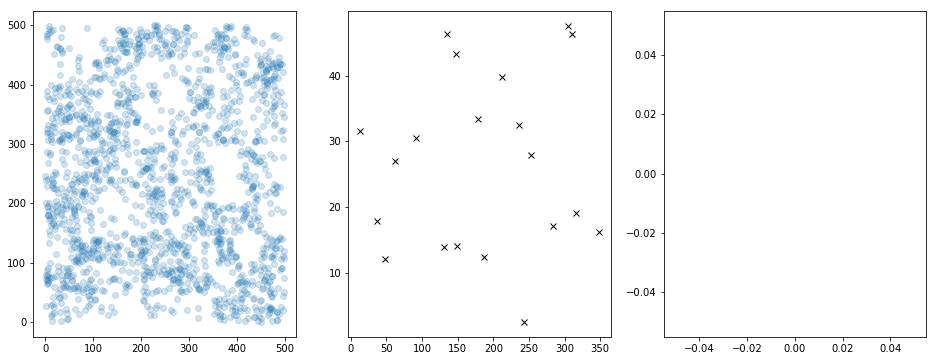

In [8]:
fig, axes = plt.subplots(ncols=3, figsize=(16,6))

xcs = details.backgrounds[1]
ycs = details.backgrounds[2]
axes[0].scatter(xcs, ycs, alpha=0.2)

m = (xcs < 50) & (ycs < 50)
times = details.backgrounds[0][m]
axes[1].scatter(times, xcs[m], marker="x", color="black", linewidth=1)

m = (xcs > 150) & (xcs < 200) & (ycs < 50)
times = details.backgrounds[0][m]
axes[2].scatter(times, xcs[m], marker="x", color="black", linewidth=1)

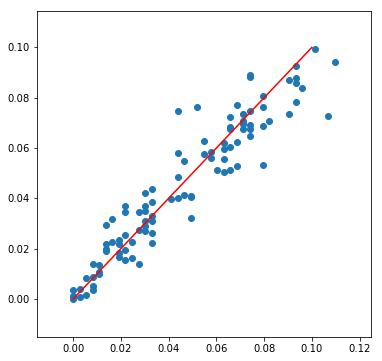

In [9]:
xg = np.floor(details.backgrounds[1] / 50).astype(np.int)
yg = np.floor(details.backgrounds[2] / 50).astype(np.int)
mu = np.zeros_like(rates)
for x, y in zip(xg, yg):
    mu[y,x] += 1
mu /= 365
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(mu.flatten(), rates.flatten())
ax.plot([0,0.1], [0,0.1], color="red")
None

## Combined

In [10]:
points = details.points

m = (points[1] >= 0) & (points[1] < 500) & (points[2] >= 0) & (points[2] < 500)
points = points[:,m]
points.shape, details.points.shape

((3, 3294), (3, 3298))

In [11]:
time_unit = source_sepp.make_time_unit(datetime.timedelta(days=1))
timed_points = source_sepp.scale_to_real_time(points, datetime.datetime(2017,1,1),
    time_unit)
timed_points.time_range

(numpy.datetime64('2017-01-01T05:19:13.117'),
 numpy.datetime64('2017-12-31T22:34:40.034'))

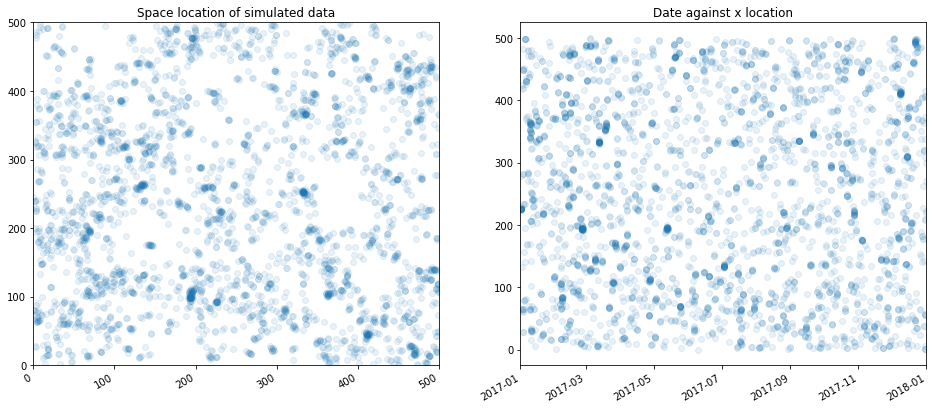

In [12]:
fig, ax = plt.subplots(ncols=2, figsize=(16,7))

ax[0].scatter(timed_points.xcoords, timed_points.ycoords, alpha=0.1)
ax[0].set_title("Space location of simulated data")
ax[0].set(xlim=[0,500], ylim=[0,500])

times = timed_points.times_datetime()
ax[1].scatter(times, timed_points.xcoords, alpha=0.1)
ax[1].set_xlim([datetime.datetime(2017,1,1), datetime.datetime(2018,1,1)])
ax[1].set_title("Date against x location")
fig.autofmt_xdate()
None

# Fit

In [13]:
tk = sepp.sepp_fixed.ExpTimeKernel(10)
sk = sepp.sepp_fixed.GaussianSpaceKernel(np.sqrt(2))
trainer = sepp.sepp_fixed.GridTrainer(grid, tk, sk)
trainer.data = timed_points
model = trainer.train(datetime.datetime(2018,1,1), iterations=1)

In [14]:
model

GridModel(mu size=(10, 10), T=364.7783204050926, theta=0.49488011936393184, f=ExpTimeKernel(omega=10), g=GaussianSpaceKernel(sigma=1.4142135623730951))

In [15]:
T, data = trainer.make_data(datetime.datetime(2018,1,1))
model = trainer.initial_model(T, data)
for _ in range(20):
    opt = trainer._optimiser(model, data)
    model = opt.iterate()
    print(model)

GridModel(mu size=(10, 10), T=364.7783204050926, theta=0.49488011936393184, f=ExpTimeKernel(omega=10), g=GaussianSpaceKernel(sigma=1.4142135623730951))
GridModel(mu size=(10, 10), T=364.7783204050926, theta=0.49577385027056353, f=ExpTimeKernel(omega=10), g=GaussianSpaceKernel(sigma=1.4142135623730951))
GridModel(mu size=(10, 10), T=364.7783204050926, theta=0.49577990810554523, f=ExpTimeKernel(omega=10), g=GaussianSpaceKernel(sigma=1.4142135623730951))
GridModel(mu size=(10, 10), T=364.7783204050926, theta=0.49577996233601757, f=ExpTimeKernel(omega=10), g=GaussianSpaceKernel(sigma=1.4142135623730951))
GridModel(mu size=(10, 10), T=364.7783204050926, theta=0.49577996289202586, f=ExpTimeKernel(omega=10), g=GaussianSpaceKernel(sigma=1.4142135623730951))
GridModel(mu size=(10, 10), T=364.7783204050926, theta=0.49577996289812276, f=ExpTimeKernel(omega=10), g=GaussianSpaceKernel(sigma=1.4142135623730951))
GridModel(mu size=(10, 10), T=364.7783204050926, theta=0.495779962898192, f=ExpTimeKerne

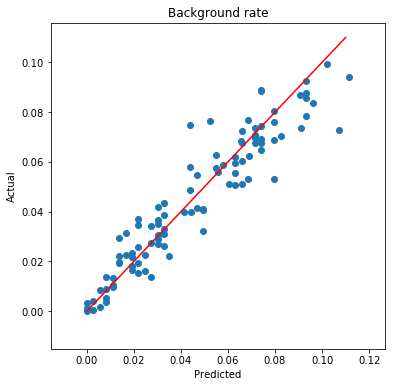

In [16]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(model.mu.flatten() * grid.xsize * grid.ysize, rates.flatten())
ax.plot([0,0.11], [0,0.11], color="red")
ax.set(xlabel="Predicted", ylabel="Actual", title="Background rate")
None

### With Theta fixed

In [51]:
tk = sepp.sepp_fixed.ExpTimeKernel(10)
sk = sepp.sepp_fixed.GaussianSpaceKernel(np.sqrt(2))
trainer = sepp.sepp_fixed.GridTrainerFixedTheta(grid, tk, sk, 0.5)
trainer.data = timed_points
model = trainer.train(datetime.datetime(2018,1,1), iterations=1)
model

GridModel(mu size=(10, 10), T=364.7783204050926, theta=0.5, f=ExpTimeKernel(omega=10), g=GaussianSpaceKernel(sigma=1.4142135623730951))

In [52]:
T, data = trainer.make_data(datetime.datetime(2018,1,1))
model = trainer.initial_model(T, data)
for _ in range(20):
    opt = trainer._optimiser(model, data)
    model = opt.iterate()
model

GridModel(mu size=(10, 10), T=364.7783204050926, theta=0.5, f=ExpTimeKernel(omega=10), g=GaussianSpaceKernel(sigma=1.4142135623730951))

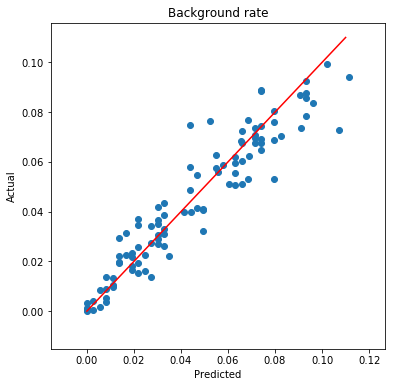

In [53]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(model.mu.flatten() * grid.xsize * grid.ysize, rates.flatten())
ax.plot([0,0.11], [0,0.11], color="red")
ax.set(xlabel="Predicted", ylabel="Actual", title="Background rate")
None

## With KDE background

In [42]:
tk = sepp.sepp_fixed.ExpTimeKernel(10)
sk = sepp.sepp_fixed.GaussianSpaceKernel(np.sqrt(2))
bkp = sepp.sepp_full.FixedBandwidthKernelProvider(5)
trainer = sepp.sepp_fixed.KDETrainer(tk, sk, bkp)
trainer.data = timed_points
model = trainer.train(datetime.datetime(2018,1,1), iterations=1)

In [43]:
model

KDEModel(T=364.7783204050926, mu=4.543513357581701, background=<open_cp.kernels.GaussianBase object at 0x000001D3B680D400>, theta=0.4968502819317674, f=ExpTimeKernel(omega=10), g=GaussianSpaceKernel(sigma=1.4142135623730951)

In [44]:
T, data = trainer.make_data(datetime.datetime(2018,1,1))
model = trainer.initial_model(T, data)
for _ in range(20):
    opt = trainer._optimiser(model, data)
    model = opt.iterate()
model

KDEModel(T=364.7783204050926, mu=4.546335998784987, background=<open_cp.kernels.GaussianBase object at 0x000001D3B5C677F0>, theta=0.49653770199332176, f=ExpTimeKernel(omega=10), g=GaussianSpaceKernel(sigma=1.4142135623730951)

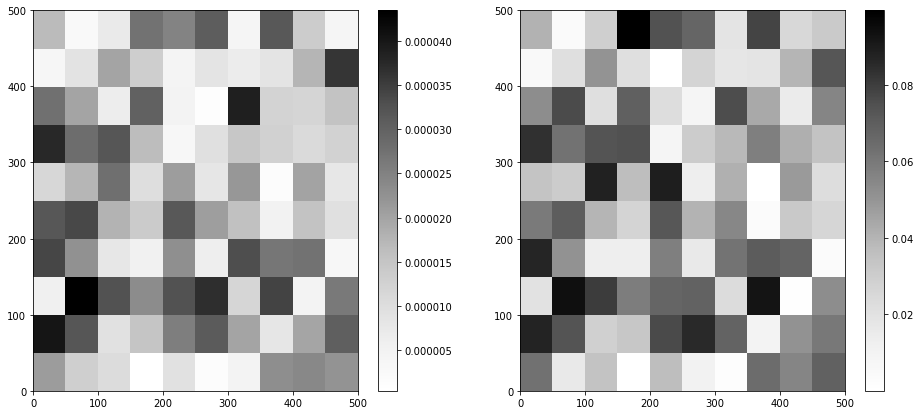

In [45]:
fig, axes = plt.subplots(ncols=2, figsize=(16,7))

pred = open_cp.predictors.KernelRiskPredictor(model.background_kernel)
pred = open_cp.predictors.GridPredictionArray.from_continuous_prediction_grid(pred, grid)
ax = axes[0]
m = ax.pcolor(*pred.mesh_data(), pred.intensity_matrix * model.mu, cmap="Greys", rasterized=True)
cb = fig.colorbar(m, ax=ax)

pred = open_cp.predictors.GridPredictionArray(grid.xsize, grid.ysize, rates, grid.xoffset, grid.yoffset)
ax = axes[1]
m = ax.pcolor(*pred.mesh_data(), pred.intensity_matrix, cmap="Greys", rasterized=True)
cb = fig.colorbar(m, ax=ax)

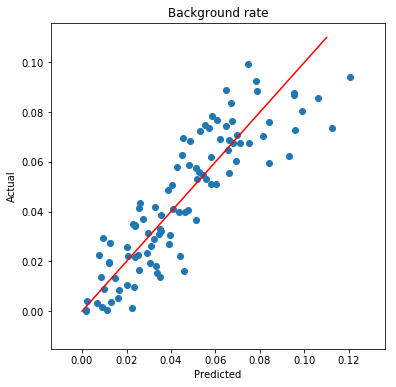

In [46]:
fig, ax = plt.subplots(figsize=(6, 6))

pred = open_cp.predictors.KernelRiskPredictor(model.background_kernel)
pred = open_cp.predictors.GridPredictionArray.from_continuous_prediction_grid(pred, grid)
ax.scatter(pred.intensity_matrix * grid.xsize * grid.ysize * model.mu, rates.flatten())
ax.plot([0,0.11], [0,0.11], color="red")
ax.set(xlabel="Predicted", ylabel="Actual", title="Background rate")
None

### With fixed theta

In [59]:
import importlib
importlib.reload(sepp.sepp_fixed)

<module 'sepp.sepp_fixed' from 'C:\\Users\\Matthew\\Documents\\m_drive\\GitHub\\sepp\\sepp\\sepp_fixed.py'>

In [60]:
tk = sepp.sepp_fixed.ExpTimeKernel(10)
sk = sepp.sepp_fixed.GaussianSpaceKernel(np.sqrt(2))
bkp = sepp.sepp_full.FixedBandwidthKernelProvider(5)
trainer = sepp.sepp_fixed.KDETrainerFixedTheta(tk, sk, bkp, 0.5)
trainer.data = timed_points
model = trainer.train(datetime.datetime(2018,1,1), iterations=1)
model

KDEModel(T=364.7783204050926, mu=4.543513357581701, background=<open_cp.kernels.GaussianBase object at 0x000001D3B6804BA8>, theta=0.5, f=ExpTimeKernel(omega=10), g=GaussianSpaceKernel(sigma=1.4142135623730951)

In [61]:
T, data = trainer.make_data(datetime.datetime(2018,1,1))
model = trainer.initial_model(T, data)
for _ in range(20):
    opt = trainer._optimiser(model, data)
    model = opt.iterate()
model

KDEModel(T=364.7783204050926, mu=4.546301931257379, background=<open_cp.kernels.GaussianBase object at 0x000001D3B595FE80>, theta=0.5, f=ExpTimeKernel(omega=10), g=GaussianSpaceKernel(sigma=1.4142135623730951)

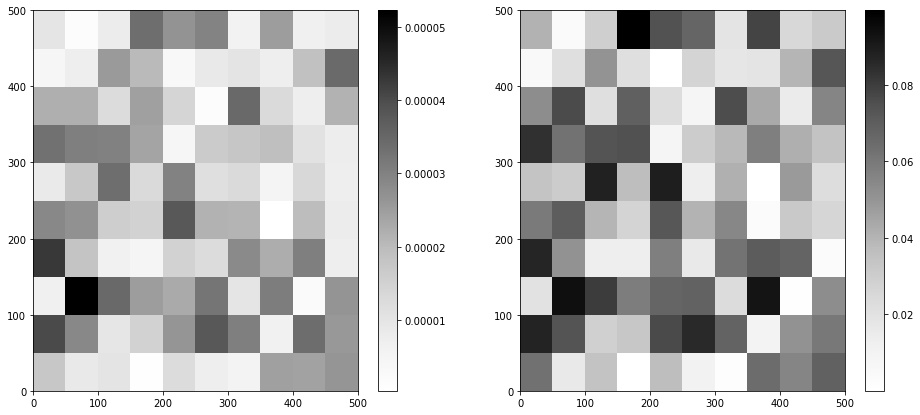

In [62]:
fig, axes = plt.subplots(ncols=2, figsize=(16,7))

pred = open_cp.predictors.KernelRiskPredictor(model.background_kernel)
pred = open_cp.predictors.GridPredictionArray.from_continuous_prediction_grid(pred, grid)
ax = axes[0]
m = ax.pcolor(*pred.mesh_data(), pred.intensity_matrix * model.mu, cmap="Greys", rasterized=True)
cb = fig.colorbar(m, ax=ax)

pred = open_cp.predictors.GridPredictionArray(grid.xsize, grid.ysize, rates, grid.xoffset, grid.yoffset)
ax = axes[1]
m = ax.pcolor(*pred.mesh_data(), pred.intensity_matrix, cmap="Greys", rasterized=True)
cb = fig.colorbar(m, ax=ax)

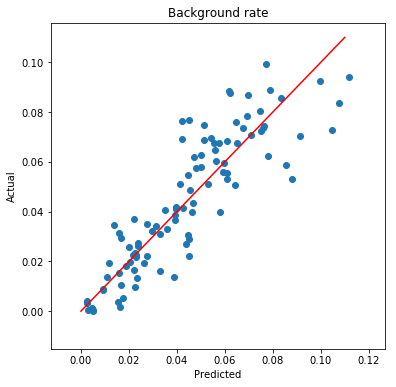

In [63]:
fig, ax = plt.subplots(figsize=(6, 6))

pred = open_cp.predictors.KernelRiskPredictor(model.background_kernel)
pred = open_cp.predictors.GridPredictionArray.from_continuous_prediction_grid(pred, grid)
ax.scatter(pred.intensity_matrix * grid.xsize * grid.ysize * model.mu, rates.flatten())
ax.plot([0,0.11], [0,0.11], color="red")
ax.set(xlabel="Predicted", ylabel="Actual", title="Background rate")
None